# 朴素贝叶斯算法(Naive Bayes)

>前两张学习的knn和决策树分类都直接给出了答案，但是不能避免一些分类错误，本章学习的方法给出的是一个最优的类别猜测结果，并且给出概率估计值。

* `朴素`一词是因为整个过程都是最原始最简单的假设<特征之间独立性假设>。

>是基于贝叶斯定理和特征条件独立假设的分类方法。

* 优点：数据少也可以有效，可以处理多分类问题
* 缺点：输入数据的准备方式较为敏感

__贝叶斯决策理论:__核心就是选择具有最高概率的决策。朴素贝叶斯就是基于贝叶斯决策理论的一种分类方法。

## 概率知识复习
* 条件概率
    - P(A|B) = P(A·B)/P(B)
![例子](https://ws1.sinaimg.cn/large/006tNbRwly1fy5hufmoa3j31ek0jqtdy.jpg)


例题：

* P(A·B)-->在B桶中抽到白球的概率-->1/7；
* P(B)-->B桶中有3块石头的概率-->3/7；
* 根据公式P(A|B) = (1/7)/(3/7) = 1/3

__贝叶斯准则__
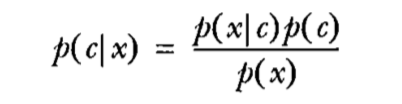


## 用朴素贝叶斯进行文档分类
文档分类是机器学习的一个重要应用。可以观察文档中的词，将每个词的出现或者不出现作为一个特征，这样特征数目就等同于词汇表的词数。

一般步骤：
* 1） 收集数据
* 2）准备数据(数值型、布尔型)
* 3）分析数据(特征多，用直方图效果好)
* 4）训练算法(计算不同独立特征多条件概率)
* 5）测试算法(计算错误率)
* 6）使用算法(一般应用于文档分类，但也无限制)

>通常每个特征需要N个样本，10个特征需要N^10个样本；如果特征相互独立，那么样本数就变成1000*N

`独立`：一个特征或者单词出现与它和其它单词相邻没有关系。
    * 这个假设也是朴素贝叶斯分类中朴素一词的含义。
    * 另一个假设是每个特征都是等重要的，即每个词是等权重的，只考虑词是否出现，不考虑出现次数。

## python进行文本分类
### 准备数据：词向量构建
思路在于：
* 构建一个词表，包含文本的所有词，长度是文本中不同词的数量
* 对每一句话进行词向量化
    - 构建一个同词表等长的0向量
    - 判断每句话中的词在词表中是否出现，出现在0向量中相应位置记为1

In [83]:
def loadDataSet():
    '''
    postingList: 切词后的句子
    classVec:数据集对应的分类标签
    '''
    postingList = [ ['my', 'dog', 'has', 'flea', 'problems', 'help', 'please'],
                         ['maybe', 'not', 'take', 'him', 'to', 'dog', 'park', 'stupid'],
                         ['my', 'dalmation', 'is', 'so', 'cute', 'I', 'love', 'him'],
                         ['stop', 'posting', 'stupid', 'worthless', 'garbage'],
                         ['mr', 'licks', 'ate', 'my', 'steak', 'how', 'to', 'stop', 'him'],
                         ['quit', 'buying', 'worthless', 'dog', 'food', 'stupid']]
    
    classVec = [0,1,0,1,0,1]    #1代表侮辱性文字，0代表正常言论
    return postingList,classVec

def creatVocabList(dataset):
    '''
    构建词表
    output:词表
    '''
    vocabSet = set([])
    for doc in dataset:
        vocabSet = vocabSet | set(doc) # 通过对两个集合取并，找出所有非重复的单词
    return list(vocabSet)
#对于这个函数，自己的思路是将所有句子用extend拼接成一个大list，然后用set来得到词表

def Words2Vec(vocabSet, inputSet):
    '''
    vocabSet：词表
    inputSet：输入需要向量化的句子
    output：输出文档向量(0,1)形式
    '''
    return_vec = [0] * len(vocabSet) 
    # 创建与词汇表等长的列表向量
    for word in inputSet:
        if word in vocabSet:
            return_vec[vocabSet.index(word)] = 1 # 出现的单词赋1
        else: print("the word %s is not in list" % word)
    return return_vec

if __name__=='__main__':
    dataSet,labels = loadDataSet()
    vocabSet = creatVocabList(dataSet)
    wordVect = Words2Vec(vocabSet,dataSet[0])
    print('the vocabulary list is :'+'\n'+repr(vocabSet)+'\n')
    print('word2vect of sentence 2 is : '+'\n'+repr(wordVect))
    trainvec = []
    for i in range(len(dataSet)):
        wordVect = Words2Vec(vocabSet,dataSet[i])
        trainvec.append(wordVect)
    trainvec

the vocabulary list is :
['to', 'how', 'not', 'dalmation', 'love', 'garbage', 'licks', 'my', 'mr', 'quit', 'so', 'I', 'steak', 'posting', 'food', 'flea', 'take', 'is', 'problems', 'park', 'stupid', 'please', 'him', 'ate', 'help', 'maybe', 'cute', 'worthless', 'has', 'dog', 'stop', 'buying']

word2vect of sentence 2 is : 
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0]


### 训练算法：根据词向量计算概率
目的是：输入训练样本和标签，可以得到词表中`每个词是某一类别的概率`。即计算P(Ci|wi)的概率。比如在wi这个词出现的条件下，它是类别1的概率。后验求条件概率需要用到贝叶斯公式。

>**朴素贝叶斯分类器就是基于数据集D，估计先验概率P(c)，再对每个属性，估计条件概率P(wi | c).**
* 先验概率是属于某个类别的样本集合Dc/样本总数，是横向计算
* 条件概率是在上述样本空间内，某个样本属性取值的集合/Dc。纵向计算

![贝叶斯公式](https://ws1.sinaimg.cn/large/006tNbRwly1fy5hugaa9uj30x409a761.jpg)
W是一个特征向量，长度和词表长度相同；c是对应的类别；P(W) = ∑P(W|ci)·P(ci)全概率公式得到

In [84]:
import numpy as np
def NaiveBayes0(trainMatrix,trainCategory):
    '''
    用朴素贝叶斯计算先验概率P(ci)和条件概率P(w | ci)
    trainMatrix:特征向量组成的矩阵
    trainCategory:各特征向量对应的分类
    '''
    
    numTrain = len(trainMatrix) #训练的文档个数
    numWords = len(trainMatrix[0]) #词表的大小，即特征的大小
    
    p1 = sum(trainCategory)/float(numTrain)  #分类1的概率p(y=1)，标签中1出现的次数/总文档数；p(y=0) = 1-p1
    p0Num = np.zeros(numWords); p1Num = np.zeros(numWords)      #初始化为0
    p0Denom = 0.0; p1Denom = 0.0 
    
    #对每一个训练文档
    for i in range(numTrain):
        
        #出现侮辱性词语
        if trainCategory[i] == 1:
            p1Num += trainMatrix[i] 
            #c=1条件下，统计某个单词出现的个数(因为每个特征向量都是等长的，其中每个词条位置固定，可以直接相加来计算次数)，用于计算p(wi/c=1)
            p1Denom += sum(trainMatrix[i]) 
            #累计c=1的所有单词数量
        else:
            p0Num += trainMatrix[i] 
            p0Denom += sum(trainMatrix[i]) 
            
    p1Vect = p1Num/float(p1Denom)     #p(w/c=1)   
    p0Vect = p0Num/float(p0Denom)     #p(w/c=0)  
    
    return p0Vect,p1Vect,p1

if __name__ == '__main__':
    p0Vect,p1Vect,p1 = NaiveBayes0(trainvec,labels)
    print("先验概率 p(c=1) = ",p1)  #classVec = [0,1,0,1,0,1] ,so p1=0.5
    print("每个特征的条件概率 p(w | c=1) = ",p1Vect)
    print("c=1,the word with the max Probability=(%f), is(%s)"%(np.max(p1Vect),vocabSet[np.argmax(p1Vect)]))
    # 对词条按概率排序
    dt = list(p1Vect)
    result = dict(list(zip(vocabSet,dt)))
    result_sort = sorted(result.items(),key=lambda x:x[1],reverse=True)[0:5]
    print('词条属于侮辱性词语的概率排序：'+repr(result_sort))

先验概率 p(c=1) =  0.5
每个特征的条件概率 p(w | c=1) =  [0.05263158 0.         0.05263158 0.         0.         0.05263158
 0.         0.         0.         0.05263158 0.         0.
 0.         0.05263158 0.05263158 0.         0.05263158 0.
 0.         0.05263158 0.15789474 0.         0.05263158 0.
 0.         0.05263158 0.         0.10526316 0.         0.10526316
 0.05263158 0.05263158]
c=1,the word with the max Probability=(0.157895), is(stupid)
词条属于侮辱性词语的概率排序：[('stupid', 0.15789473684210525), ('worthless', 0.10526315789473684), ('dog', 0.10526315789473684), ('to', 0.05263157894736842), ('not', 0.05263157894736842)]


>这个结果表示，在侮辱性的类别中，词条stupid一词是出现频率最高的词，即这个词是侮辱性词语的概率最大。

* 在计算多个概率乘积会因为某个概率值为0，导致乘积也为0，可以初始化所有词为1，分母初始化为2。
* 小数相乘会出现下溢现象，即四舍五入的时候会变成0，需要取log

>统计学习方法里面提到，原来的估计方法是极大似然估计，可以用贝叶斯估计来优化，具体做法如下图：
![拉普拉斯平滑](https://ws3.sinaimg.cn/large/006tNbRwly1fy5hyizrs5j30q006udgq.jpg)

In [85]:
def NaiveBayes1(trainMatrix,trainCategory):
    numTrain = len(trainMatrix) #训练的文档个数
    numWords = len(trainMatrix[0]) #词汇表的大小，即特征的大小
    p1 = sum(trainCategory)/float(numTrain)  #分类1的概率p(y=1)，这里是二分类，所以，p0=1-p1
    p0Num = np.ones(numWords); p1Num = np.ones(numWords)      #change to 1 ,一般sigma = 1
    p0Denom = 2.0; p1Denom = 2.0                        # change to 2.0 因为有两个类别
    for i in range(numTrain):
        if trainCategory[i] == 1:
            p1Num += trainMatrix[i] #y=1条件下，统计某个单词出现的个数，用于计算p(w/y=1)
            p1Denom += sum(trainMatrix[i]) #累计y=1的所有单词数量
        else:
            p0Num += trainMatrix[i] #y=0条件下，统计某个单词出现的个数，用于计算p(w/y=0)
            p0Denom += sum(trainMatrix[i]) #累计y=0的所有单词数量
    p1Vect = np.log(p1Num/float(p1Denom))         #change to log()
    p0Vect = np.log(p0Num/float(p0Denom))          #change to log()
    return p0Vect,p1Vect,p1

In [86]:
NaiveBayes1(trainvec,labels)

(array([-2.56494936, -2.56494936, -3.25809654, -2.56494936, -2.56494936,
        -3.25809654, -2.56494936, -1.87180218, -2.56494936, -3.25809654,
        -2.56494936, -2.56494936, -2.56494936, -3.25809654, -3.25809654,
        -2.56494936, -3.25809654, -2.56494936, -2.56494936, -3.25809654,
        -3.25809654, -2.56494936, -2.15948425, -2.56494936, -2.56494936,
        -3.25809654, -2.56494936, -3.25809654, -2.56494936, -2.56494936,
        -2.56494936, -3.25809654]),
 array([-2.35137526, -3.04452244, -2.35137526, -3.04452244, -3.04452244,
        -2.35137526, -3.04452244, -3.04452244, -3.04452244, -2.35137526,
        -3.04452244, -3.04452244, -3.04452244, -2.35137526, -2.35137526,
        -3.04452244, -2.35137526, -3.04452244, -3.04452244, -2.35137526,
        -1.65822808, -3.04452244, -2.35137526, -3.04452244, -3.04452244,
        -2.35137526, -3.04452244, -1.94591015, -3.04452244, -1.94591015,
        -2.35137526, -2.35137526]),
 0.5)

取log自然就是负值

[关于朴素贝叶斯算法推导](https://www.cnblogs.com/liuwu265/p/4685361.html)

李航书中关于朴素贝叶斯分类器在最后部分，分母问题上不是很清楚，这篇文章帮助我理解，为什么分母可以约去，只考虑分子部分。

In [87]:
def classify(testVec, p0Vec, p1Vec, pClass1):
    '''
    朴素贝叶斯分类器-->用于计算特征的类别
    testVec:特征向量(测试样本)
    p0Vect:P(w | c=0)条件概率
    p1Vect:P(w | c =1)条件概率
    pClass1:P(c = i)先验概率
    output:返回分类的结果1:侮辱性，0:非侮辱性。
    '''
    p1 = sum(testVec * p1Vec) + np.log(pClass1)    #因为是log,ln(a*b) = ln(a)+ln(b)所以这里是求和以及+号操作
    #p(c=1/w) = p(w/c=1) * p(c=1)因为根据朴素贝叶斯算法公式，分母是P(C = Ci),分母对于已知的，对估计结果不影响，可以约去；至于乘上testVec,不是很清楚。
    
    p0 = sum(testVec * p0Vec) + np.log(1.0 - pClass1) #p(y=0) = 1 - p(y=1)
    if p1 > p0: #选取最大的概率的类
        return 1
    else: 
        return 0

In [88]:
p0V,p1V,p1 = NaiveBayes1(trainvec,labels)
test0 = ['love', 'my', 'dalmation']
testVec0 = Words2Vec(vocabSet, test0)
print(test0,'classified as: ',classify(testVec0,p0V,p1V,p1))
test1 = ['stupid', 'garbage']
testVec1 = Words2Vec(vocabSet, test1)
print(test1,'classified as: ',classify(testVec1,p0V,p1V,p1))

['love', 'my', 'dalmation'] classified as:  0
['stupid', 'garbage'] classified as:  1


## 词袋模型(bag of words model)
* 对于每个词是否出现---->词集模型(`set of words model`)
* 对于每个词可以多次出现--->词袋模型(`bag of words model`)

因此需要对词向量模型做一些修改
* 每当遇到一个单词，模型会增加词向量中对应的值，而不是全为1.

idea:
* 构建一个长度同词表的0向量
* 对样本中每个词遍历:
    - 判断该词是否在词表中:
        - 在,则在0向量相应位置记1

In [89]:
def bagOfWordsVec(vocabSet, inputSet):
    '''
    词袋模型，需要统计某个词条出现的次数
    vocabSet:词表
    inputSet:一个样本；特征向量
    output:词向量
    '''
    returnVec = [0]*len(vocabSet)
    for word in inputSet:
        if word in vocabSet:
            returnVec[vocabSet.index(word)] += 1 #出现一次，累加一次
    return returnVec

In [90]:
test_Vec = bagOfWordsVec(vocabSet,['i','hate','this','stupid','dog'])
print('词袋模型的词向量:'+repr(test_Vec))

词袋模型的词向量:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]


## 练习-用朴素贝叶斯分类器过滤垃圾邮件
__步骤依然是：__
* 收集数据
* 准备数据-->文件文本向量化
* 分析数据
* 训练算法-->训练模型
* 测试算法-->查看文档分类的错误率
* 使用算法-->构建完整程序，并将分类结果以及错误分类情况输出

>数据包含已经分类的普通邮件和垃圾邮件各25封,需要做的是将数据集划分成训练集和测试集；将划分好的数据集进行词向量化；将词向量给分类器进行分类；根据标签集统计分类错误率；由于划分数据集是随机的，需要重复多次取均值。

idea:
* 划分数据集，随机采样-->书上是4:1
* 词向量化
* 训练
* 计算错误率
* 重新划分数据集(重复)

__准备数据__
* 读取文本数据，预处理，只保留文本(需要用到正则表达式)


In [97]:
import re
def textParse(bigString):
    '''
    字符串处理函数：保留英文字符和数字作为词条，且长度>2
    bigString:输入的文本文件
    output:返回一个词列表
    '''
    listOfTokens = re.split(r'\W*', bigString) #只需要字符和数字
    return [tok.lower() for tok in listOfTokens if len(tok) > 2] #变成小写，过滤长度小于3的字符串 

In [146]:
def spamTest():
    '''
    垃圾邮件分类函数
    '''
    docList=[]; classList = []; fullText =[]
    #分别是总邮件列表，邮件对应分类标签集合，所有句子组成的文本
    for i in list(range(1,26)): #每个文件夹，有25个文件
        wordList = textParse(open('./email/spam/%d.txt' % i,encoding='ISO-8859-1').read())
        docList.append(wordList)
        fullText.extend(wordList)
        classList.append(1)
        wordList = textParse(open('./email/ham/%d.txt' % i,encoding='ISO-8859-1').read())
        docList.append(wordList)
        fullText.extend(wordList)
        classList.append(0)
    
    vocabularyList = creatVocabList(docList)#建总词表
    trainingSet =list( range(50)); testSet=[]   #create test set,这里其实是val set，而且只保存了下标
    for i in list(range(10)):
        randIndex = int(np.random.uniform(0,len(trainingSet)))
        testSet.append(trainingSet[randIndex])
        del(trainingSet[randIndex])  #随机选取10个，并且从train中删除
    '''
    抽样将数据集一开始合并成同一个数组比较好，将分类标签全部加在list[0]位置，或者把数据集append方法加在标签集后面便于后续操作。
    抽样可方法很多，无非是记住index，然后从数据集中选择，自己选用的是random.sample()函数，从1-50数组中抽样得到index_list，然后划分。
    其中用了map(),和filter()方法,可读性更强。
    '''  
    trainMat=[]; trainClasses = []
    for docIndex in trainingSet:#获得索引
        trainMat.append(bagOfWordsVec(vocabularyList, docList[docIndex]))
        trainClasses.append(classList[docIndex])
    p0V,p1V,pSpam = NaiveBayes1(trainMat,trainClasses) #训练，得到条件概率
    errorCount = 0
    for docIndex in testSet:        #classify the remaining items
        wordVector = bagOfWordsVec(vocabularyList, docList[docIndex])
        if classify(wordVector,p0V,p1V,pSpam) != classList[docIndex]: #用于test/val
            errorCount += 1
            #print( "classification error",docList[docIndex])
    #print('the error rate is: ',float(errorCount)/len(testSet))
    return float(errorCount)/len(testSet)

In [147]:
spamTest()

/Users/tony/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


0.1

### 留出法
由于随机划分数据集是随机的，单次划分结果不够稳定，需要多次重复取均值

In [148]:
Er = []
for i in range(20):
    error = spamTest()
    Er.extend([error])
mean_error = sum(Er)/20
print('20次重复划分数据集的平均误差：%f'%mean_error)

/Users/tony/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


20次重复划分数据集的平均误差：0.050000


__关于抽样的一些想法和实现__
* 1.用random.sample()对数组抽样，得到训练集index
* 2.用map(),从未划分的数据集中，按index索引取样
* 3.用filter(),得到测试集的index
* 4.同2

In [133]:
def splitDataSet(docList,classList,size):
    '''
    随机抽样-数据集划分
    docList:未划分的训练集
    classList:未划分的标签集
    sample:采样大小
    output:划分后的训练集、测试集及其对应的分类标签
    '''
    import random
    #训练集
    index_train = random.sample(range(50),size)
    trainSet = list(map(lambda x:docList[x],index_train))
    classSet_train = list(map(lambda x:classList[x],index_train))
    #测试集
    index_test = list(filter(lambda x:x not in index_train,range(50)))
    testSet = list(map(lambda x:docList[x],index_test))
    classSet_test = list(map(lambda x:classList[x],index_test))
    return trainSet,classSet_train,testSet,classSet_test

In [60]:
dtrain,labeltrain,dtest,labeltest = splitDataSet(docList,classList,40)

## 小结
关于朴素贝叶斯算法，核心在于通过朴素贝叶斯公式和‘朴素’这个特点，即通过假设随机变量之间两两独立，从而简化了特征之间的关系，利用先验概率和条件概率，来估算后验概率，选择后验概率中的最大概率，来确定最终的类别。
>主要有以下几个注意点：
* `词向量化(word2Vector)`：主要是通过构造词表，即将切词后的所有文本组成一个集合，组成一个n维的词向量，每个词在相应的位置，出现记1，不出现记0。
* `词集模型(set of words model)`:就是将词是否出现作为判断依据，只考虑是否出现，而不考虑出现的次数。
* `词袋模型(bag of words model)`:将词出现的次数考虑在内，来生成词向量。
* `朴素`的含义：对条件概率做了独立性假设，假设各特征属性之间相互独立。
* 对于`后验概率最大化`，李航书中解释是等价于`期望风险最小化`，具体可以看推导过程。
* 由于用朴素贝叶斯法的参数估计采用的是`极大似然估计`，可能会出现特征属性集合为0而导致估计的概率乘积为0，导致结果出现偏差，需要用到贝叶斯估计来修正，通常在随机变量各取值频数上加一个正数λ，=0是极大似然估计，=1是`拉普拉斯平滑`，通常分子是λ，分母是Kλ,K表示分类类别数量。
* `下溢问题`(太小的数相乘导致取值近似为0)可以用取对数来解决，要降低错误率可以通过去停用词等方法改进。